# Classification Problem Statement 

### Predicting Loan Defaults

Predicting loan defaults is an extremely common use case for machine
learning in banking, one of DataRobot's main target industries. As a
loan officer, you are responsible for determining which loans are
going to be the most profitable and worthy of lending money to. Based
on a loan application from a potential client, you would like to
predict whether the loan will be paid back in time.

### Data

You will be working with a loan dataset
from LendingClub.com,
a US peer-to-peer lending company. Your classification target is
`is_bad`.

### Task

Partition your data into a holdout set and 5 stratified CV folds. Pick
any two machine learning algorithms from the list below, and build a
binary classification model with each of them:
- Regularized Logistic Regression (scikit-learn)  
- Gradient Boosting Machine (scikit-learn, XGBoost or LightGBM)
- Neural Network (Keras), with the architecture of your choice

Both of your models must make use of numeric, categorical, text, and
date features. Compute out-of-sample LogLoss and F1 scores on
cross-validation and holdout. Which one of your two models would you
recommend to deploy? Explain your decision.

*(Advanced, optional)*: Which 3 features are the most impactful for your model?

Explain your methodology.

### Data Dictionary
|	Column Name|Type|Description|Category|
|---|---|---|---|
|`addr_state`|Categorical|Customer State|Customer
|`annual_inc`|Numeric|Annual Income|Customer
|`collections_12_mths_ex_med`|Numeric|(Credit based)|Customer
|`debt-to-income`|Numeric|Ratio of debt to income|Loan
|`delinq_2yrs`|Numeric|Any delinquency in last 2 years|Customer
|`earliest_cr_line`|Date|First credit date|Customer
|`emp_length`|Numeric|Length in current job|Customer
|`emp_title`|Text|Employee Title|Customer
|`home_ownership`|Categorical|Housing Status|Customer
|`Id`|Numeric|Sequential number|Identifier
|`initial_list_status`|Categorical|Loan status|Loan
|`inq_last_6mths`|Numeric|Number of inquiries|Customer
|`is_bad`|Numeric|1 or 0|Target
|`mths_since_last_delinq`|Numeric|Months since last delinquency|Customer
|`mths_since_last_major_derog`|Numeric|(Credit based)|Customer
|`mths_since_last_record`|Numeric|Months since last record|Customer
|`Notes`|Text|Notes taken by the administrator|Loan
|`open_acc`|Numeric|(Credit based)|Customer
|`pymnt_plan`|Categorical|Current Payment Plans|Customer
|`policy_code`|Categorical|Loan type|Loan
|`pub_rec`|Numeric|(Credit based)|Customer
|`purpose`|Text|Purpose for the loan|Loan
|`purpose_cat`|Categorical|Purpose category for the loan|Loan
|`revol_bal`|Numeric|(Credit based)|Customer
|`revol_util`|Numeric|(Credit based)|Customer
|`total_acc`|Numeric|(Credit based)|Customer
|`verification_status`|Categorical|Income Verified|Loan
|`zip_code`|Categorical|Customer zip code|Customer

In this notebook, I build a binary classification model of loan defaults using three ML methods 
- Logistic regression
- Gradient boosting machine
- Neural network 

Details of the task is shown in https://www.interviewquery.com/takehomes/datarobot-1

# Download Data

In [1]:
'''
!git clone --branch datarobot_1 https://github.com/interviewquery/takehomes.git
%cd takehomes/datarobot_1
!ls
'''

'\n!git clone --branch datarobot_1 https://github.com/interviewquery/takehomes.git\n%cd takehomes/datarobot_1\n!ls\n'

# Load Packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time 

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.cluster import KMeans

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import tensorflow as tf
from tensorflow import keras

# Data Processing

In [3]:
# Load csv
df_raw = pd.read_csv('dataset.csv')

# Drop the 'id' column as it's redundant to the table indices
df_raw.drop(['Id'],axis=1,inplace=True)

# Check the dataframe
df_raw.head()

,is_bad,emp_title,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,Notes,purpose_cat,purpose,...,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code
0,0,Time Warner Cable,10,MORTGAGE,50000.0,not verified,n,NaN,medical,Medical,...,NaN,15.0,0.0,12087,12.1,44.0,f,0.0,1,PC4
1,0,Ottawa University,1,RENT,39216.0,not verified,n,Borrower added on 04/14/11 > I will be using...,debt consolidation,My Debt Consolidation Loan,...,NaN,4.0,0.0,10114,64.0,5.0,f,0.0,2,PC1
2,0,Kennedy Wilson,4,RENT,65000.0,not verified,n,NaN,credit card,AP Personal Loan,...,NaN,4.0,0.0,81,0.6,8.0,f,0.0,3,PC4
3,0,TOWN OF PLATTEKILL,10,MORTGAGE,57500.0,not verified,n,NaN,debt consolidation,Debt Consolidation Loan,...,NaN,6.0,0.0,10030,37.1,23.0,f,0.0,2,PC2
4,0,Belmont Correctional,10,MORTGAGE,50004.0,VERIFIED - income,n,"I want to consolidate my debt, pay for a vacat...",debt consolidation,consolidate,...,NaN,8.0,0.0,10740,40.4,21.0,f,0.0,3,PC3


First thing that I want to do is to apply clustering on some categorical features so that we don't end up with too many columns when we apply ```OneHotEncoder``` later on.

The categorical columns to work on are: 
- ```'zip_code'```
- ```'addr_state'```
- ```'purpose_cat'```
- ```'purpose'```
- ```'emp_title'```
- ```'Notes'```

### ```'zip_code'``` and ```'addr_state'```

Let's deal with the easy ones. First, check for null values

In [4]:
print(df_raw['addr_state'].isnull().sum())
print(df_raw['zip_code'].isnull().sum())

0
0


No null values, which is good. 

Now, there are many ways that we can roll with since these two columns contain similar yet slightly different data. For this work, I will just delete the ```'addr_state'``` column because I'm assuming the location can be well determined using the ```'zip_code'``` information. Moreover, I will cluster ```'zip_code'``` based on their first digit. 
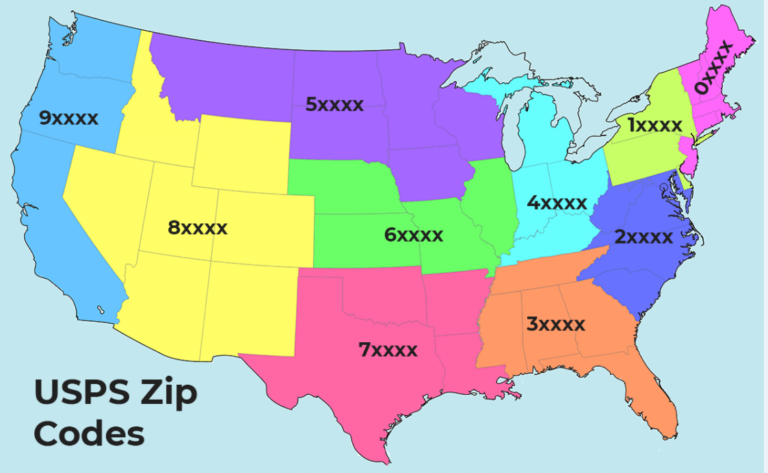
Image from https://facts.usps.com/42000-zip-codes/

In [5]:
# Drop the 'addr_state' column as it's redundant to the 'zip_code' column 
df_raw.drop(['addr_state'],axis=1,inplace=True)

In [6]:
# Change the 'zip_code' column into 'zip_code_first_digit'
# But make sure to keep it a string because it should be categorical feature
df_raw['zip_code'] = df_raw['zip_code'].apply(lambda x: x[0])
df_raw = df_raw.rename(columns={'zip_code': 'zip_code_first_digit'})

Note that this clustering is very coarse and can be improved with additional domain insight.

### ```'purpose'``` and ```'purpose_cat'```

Similar thought process here. These two columns contain redundant information. And since we want a coarser categorization to apply ```OneHotEncoder``` later, on, we'll just delete the ```'purpose'``` column and work with ```'purpose_cat'```.

In [7]:
# Drop the 'purpose' column as it's redundant to the 'purpose_cat' column 
df_raw.drop(['purpose'],axis=1,inplace=True)

Check for null values on ```'purpose_cat'``` column.

In [8]:
df_raw['purpose_cat'].isnull().sum()

0

Good! Now let's look at distinct values. 

In [9]:
print(df_raw['purpose_cat'].unique())
print(f'There are {len(df_raw["purpose_cat"].unique())} unique purpose categories')

['medical' 'debt consolidation' 'credit card' 'other' 'car' 'wedding'
 'other small business' 'house' 'small business' 'educational'
 'major purchase' 'home improvement' 'vacation'
 'debt consolidation small business' 'moving' 'credit card small business'
 'wedding small business' 'small business small business'
 'home improvement small business' 'major purchase small business'
 'educational small business' 'house small business' 'renewable energy'
 'moving small business' 'medical small business'
 'vacation small business' 'car small business']
There are 27 unique purpose categories


Of course, it's possible to cluster these purposes into coarser categories (```small business```, ```home```, etc) manually. But to automate the process, I want to use ```Word2Vec``` and apply K-means clustering on the resulting vectors. 

Considering that we don't have enough data to train a ```Word2Vec``` model from our data, we will use a pre-trained gloVe model. 
https://github.com/RaRe-Technologies/gensim-data

In [10]:
import gensim.downloader as api

info = api.info()  # show info about available models/datasets
glove = api.load("glove-twitter-25")  # download the model and return as object ready for use

One issue that we see is that long phrases like ```'educational small business'``` is not in the model vocabulary. One way to bypass that is to to have an averaged vector for each category. 

For example, the vector value for ```'educational small business'``` would be something like  ```np.avg([glove['educational'], glove['small'], glove['business']])```

In [11]:
# Save the result as a dictionary
vec_dict = {}

for purpose in df_raw['purpose_cat'].unique():
    purpose_list = purpose.split()
    vec_list = []
    
    for word in purpose_list:
        vec_list += [glove[word]]

    vec_dict[purpose] = {}
    vec_dict[purpose]['vector'] = np.average(vec_list,axis=0)

In [12]:
# Define the list of vectors 
vec_list = []
for key, item in vec_dict.items():
    vec_list += [item['vector']]

Let's do an elbow test to see what the best number of clusters is

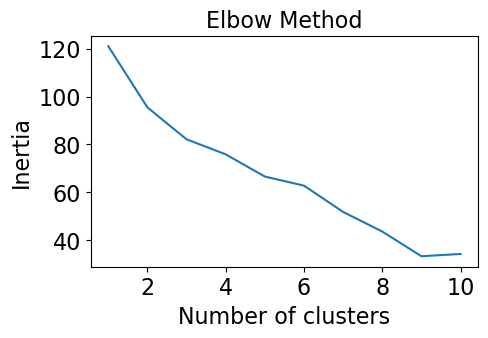

In [13]:
# Elbow method
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, 
                    max_iter=10000,
                    n_init='auto').fit(vec_list)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(5,3))

plt.plot(range(1, 11), sse)

font = 16
plt.xticks(size=font);
plt.yticks(size=font);
plt.xlabel('Number of clusters',size=font);
plt.ylabel('Inertia',size=font);
plt.title('Elbow Method',size=font)
plt.show()

The position of elbow isn't quite straitforward, but I think 5 should do it.

In [14]:
# Train the Kmeans clusterer
kmeans = KMeans(n_clusters=5,
                max_iter=10000,
                n_init='auto').fit(vec_list)

# Add classification to 'vec_dict'
for key, item in vec_dict.items():
    vec_dict[key]['classification'] = kmeans.predict([vec_dict[key]['vector']])

Now that we have ```vec_dict```, let's update the ```'purpose_cat'``` column. 

In [15]:
# Again, make sure to keep it string to keep this column categorical 
df_raw['purpose_cat'] = df_raw['purpose_cat'].apply(lambda x: str(vec_dict[x]['classification'][0]))

In [16]:
df_raw['purpose_cat']

0       4
1       4
2       0
3       4
4       4
       ..
9995    3
9996    4
9997    4
9998    0
9999    0
Name: purpose_cat, Length: 10000, dtype: object

### ```'Notes'```

To process the ```'Notes'``` column, we will use ```NLTK```'s ```VADER``` sentiment anlyzer. We'll use the ```compound``` polarity score to determine the sentiment for each note. 

The pre-processing (tokenization, removing stop words, and lemmatization) function is shown below. 

In [17]:
def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text.lower())

    # Remove stop words
    filtered_tokens = [token for token in tokens if token not in stopwords.words('english')]

    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

    # Join the tokens back into a string
    processed_text = ' '.join(lemmatized_tokens)

    return processed_text

Let's also initialize the sentiment analyzer.

In [18]:
analyzer = SentimentIntensityAnalyzer()

You can get a sentiment analysis of a piece of text as shown below. 

In [19]:
example_txt = "I am a sick man, I am a spiteful man, I am an unattractive man."
analyzer.polarity_scores(preprocess_text(example_txt))

{'neg': 0.752, 'neu': 0.248, 'pos': 0.0, 'compound': -0.8442}

One thing to note for the ```'Notes'``` column is that there are significant number of empty columns. 

In [20]:
df_raw['Notes'].isnull().sum()

3167

So our strategy will be to calculate the ```'compound'``` score for non-null entries first and fill the null entries with the mean of the non-null entries. Of course, different imputation strategies are possible. 

In [21]:
# Apply polarity_scores function to non-null entries
df_raw['Notes'] = df_raw['Notes'].apply(lambda x: np.nan if type(x)==float 
                                        else analyzer.polarity_scores(preprocess_text(x))['compound'])

# Fill null entries
df_raw['Notes'] = df_raw['Notes'].fillna(df_raw['Notes'].mean())

# Change the column name
df_raw = df_raw.rename(columns={'Notes': 'notes_sentiment_score'})

Let's see the distribution of values of the new ```'notes_sentiment_score'``` column.

In [22]:
print(f"Mean value of 'notes_sentiment_score' column is: {df_raw['notes_sentiment_score'].mean():0.2f}")

Mean value of 'notes_sentiment_score' column is: 0.51


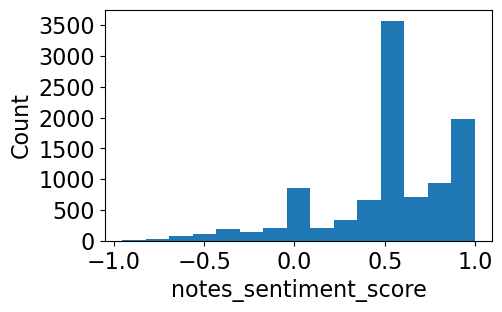

In [23]:
plt.figure(figsize=(5,3))
plt.hist(df_raw['notes_sentiment_score'],bins=15);

font = 16
plt.xlabel('notes_sentiment_score',size=font);
plt.ylabel('Count',size=font);
plt.xticks(np.arange(-1,1.1,0.5),size=font);
plt.yticks(size=font);

We see that aside from the large peak around 0.5, which corresponds to the null entries with mean values assigned, the distribution is overall skewed to the right. This makes sense as the raw ```'Notes'``` entry seem to be written by the people applying for the loans, which wouldn't include any negative information that can harm their application. 

### ```'emp_title'``` 

For the ```'emp_title'``` column, I will simply drop it for a few reasons:
- Unlike the ```'purpose_cat'``` in which the words were common noun, there can be specific name of companies, ```'meadwestvaco'``` for example, that probably will not be contained in gloVe's vocabulary. 
- I think it's reasonable to assume that the pertinent financial information will also be contained in different columns, such as `'annual_inc'`, `'debt-to-income'`, `'emp_length'`, etc.

One could imagine using a more sophisticated NLP model to convert this column to numerical value and then into different categories, but I believe it to be overkill for this case. 

In [24]:
df_raw.drop(['emp_title'],axis=1,inplace=True)

# Check for Unique Entries

In [25]:
for col in df_raw.columns:
    print(f'{col} unique values: {df_raw[col].unique()}')
    print()

is_bad unique values: [0 1]

emp_length unique values: ['10' '1' '4' '6' '2' '3' '5' '8' '7' '9' 'na' '22' '11' '33']

home_ownership unique values: ['MORTGAGE' 'RENT' 'OWN' 'OTHER' 'NONE']

annual_inc unique values: [50000. 39216. 65000. ... 66250. 47831. 70560.]

verification_status unique values: ['not verified' 'VERIFIED - income' 'VERIFIED - income source']

pymnt_plan unique values: ['n' 'y']

notes_sentiment_score unique values: [ 0.50594588 -0.128      -0.3818     ...  0.4979      0.968
  0.3365    ]

purpose_cat unique values: ['4' '0' '2' '3' '1']

zip_code_first_digit unique values: ['7' '6' '9' '1' '4' '2' '8' '3' '0' '5']

debt_to_income unique values: [10.87  9.15 11.24 ...  1.93 24.74 24.13]

delinq_2yrs unique values: [ 0.  1.  2.  4.  3.  7.  6.  5. 11. nan  8.]

earliest_cr_line unique values: ['12/01/1992' '11/01/2005' '06/01/1970' '09/01/1982' '10/01/1999'
 '12/01/1999' '11/01/1979' '04/01/2006' '02/01/2001' '05/01/1995'
 '12/01/1990' '06/01/1993' '04/01/1996' '10/0

Now we see that there are manageable number of categorical features (<10) that will not make the data too sparse. Now let's work on imputing the null entries of the data. 

# Dealing with Missing Values

First, we check the number of null values for each column.

In [26]:
df_raw.isnull().sum()

is_bad                            0
emp_length                        0
home_ownership                    0
annual_inc                        1
verification_status               0
pymnt_plan                        0
notes_sentiment_score             0
purpose_cat                       0
zip_code_first_digit              0
debt_to_income                    0
delinq_2yrs                       5
earliest_cr_line                  5
inq_last_6mths                    5
mths_since_last_delinq         6316
mths_since_last_record         9160
open_acc                          5
pub_rec                           5
revol_bal                         0
revol_util                       26
total_acc                         5
initial_list_status               0
collections_12_mths_ex_med       32
mths_since_last_major_derog       0
policy_code                       0
dtype: int64

We see that there are more than 5000 null entries for columns ```mths_since_last_delinq``` (Months since last delinquency) and ```mths_since_last_record``` (Months since last record)

Assuming that null values on these columns mean that the person either has no delinquency or record, I think it'll be reasonable to change the null values to the max value for that column

In [27]:
# Fill the null values for 'mths_since_last_delinq' and 'mths_since_last_record' columns
df_raw["mths_since_last_delinq"].fillna(df_raw['mths_since_last_delinq'].max(), inplace = True)
df_raw["mths_since_last_record"].fillna(df_raw['mths_since_last_record'].max(), inplace = True)

For the rest, drop the rows with null entries as they're only about 6% of the dataset

In [28]:
df_raw.dropna(inplace=True)

Check for null values again

In [29]:
df_raw.isnull().sum()

is_bad                         0
emp_length                     0
home_ownership                 0
annual_inc                     0
verification_status            0
pymnt_plan                     0
notes_sentiment_score          0
purpose_cat                    0
zip_code_first_digit           0
debt_to_income                 0
delinq_2yrs                    0
earliest_cr_line               0
inq_last_6mths                 0
mths_since_last_delinq         0
mths_since_last_record         0
open_acc                       0
pub_rec                        0
revol_bal                      0
revol_util                     0
total_acc                      0
initial_list_status            0
collections_12_mths_ex_med     0
mths_since_last_major_derog    0
policy_code                    0
dtype: int64

Good to go! Let's look through the data one last time before we wrap up data pre-processing.

### Miscellaneous

I want to check for unique values for each column

In [30]:
for col in df_raw.columns:
    print(f'{col} unique values: {df_raw[col].unique()}')
    print()

is_bad unique values: [0 1]

emp_length unique values: ['10' '1' '4' '6' '2' '3' '5' '8' '7' '9' 'na' '22' '11' '33']

home_ownership unique values: ['MORTGAGE' 'RENT' 'OWN' 'OTHER']

annual_inc unique values: [50000. 39216. 65000. ... 66250. 47831. 70560.]

verification_status unique values: ['not verified' 'VERIFIED - income' 'VERIFIED - income source']

pymnt_plan unique values: ['n' 'y']

notes_sentiment_score unique values: [ 0.50594588 -0.128      -0.3818     ...  0.4979      0.968
  0.3365    ]

purpose_cat unique values: ['4' '0' '2' '3' '1']

zip_code_first_digit unique values: ['7' '6' '9' '1' '4' '2' '8' '3' '0' '5']

debt_to_income unique values: [10.87  9.15 11.24 ...  1.93 24.74 24.13]

delinq_2yrs unique values: [ 0.  1.  2.  4.  3.  7.  6.  5. 11.  8.]

earliest_cr_line unique values: ['12/01/1992' '11/01/2005' '06/01/1970' '09/01/1982' '10/01/1999'
 '12/01/1999' '11/01/1979' '04/01/2006' '02/01/2001' '05/01/1995'
 '12/01/1990' '06/01/1993' '04/01/1996' '10/01/1996' '01

We note few things: 
- ```emp_length``` values are strings when they should be ints (or floats). There are also 'na' entries.
- ```earliest_cr_line``` values are strings when we want them to be some type of numerical values.

Convert ```emp_length``` by turning it into int values. We assume that 'na' entries correspond to 0

In [31]:
df_raw['emp_length'] = df_raw['emp_length'].apply(lambda x: 0 if x=='na' else int(x))

Convert ```earliest_cr_line``` into integer (number of days compared to the most recent entry in `'earliest_cr_line'`, which is `12/01/2007`). We'll make a new column `earliest_cr_line_in_days`.

In [32]:
# Declare new column
df_raw['earliest_cr_line_in_days'] = \
df_raw['earliest_cr_line'].apply(lambda x: (pd.to_datetime(df_raw['earliest_cr_line'].max()) - pd.to_datetime(x)).days)

# Drop 'earliest_cr_line'
df_raw.drop(['earliest_cr_line'],axis=1,inplace=True)

Check the data one last time.

In [33]:
df_raw.head()

,is_bad,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,notes_sentiment_score,purpose_cat,zip_code_first_digit,debt_to_income,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,earliest_cr_line_in_days
0,0,10,MORTGAGE,50000.0,not verified,n,0.505946,4,7,10.87,...,15.0,0.0,12087,12.1,44.0,f,0.0,1,PC4,5478
1,0,1,RENT,39216.0,not verified,n,-0.128000,4,6,9.15,...,4.0,0.0,10114,64.0,5.0,f,0.0,2,PC1,760
2,0,4,RENT,65000.0,not verified,n,0.505946,0,9,11.24,...,4.0,0.0,81,0.6,8.0,f,0.0,3,PC4,13697
3,0,10,MORTGAGE,57500.0,not verified,n,0.505946,4,1,6.18,...,6.0,0.0,10030,37.1,23.0,f,0.0,2,PC2,9222
4,0,10,MORTGAGE,50004.0,VERIFIED - income,n,-0.381800,4,4,19.03,...,8.0,0.0,10740,40.4,21.0,f,0.0,3,PC3,2983


Looks good! Just going to reset the index for completeness. 

In [34]:
df_raw = df_raw.reset_index()
df_raw.drop(['index'],axis=1,inplace=True)

# Dividing the Columns into Three Types

Let's divide the columns into 3 categories for ease of analysis:
- ```target```
- ```numerical```
- ```categorical```

In [35]:
# Define the list
target = ['is_bad']
numerical = []
categorical = []

# Put them in the list based on dtype
for column in df_raw.columns[1:]:
    if df_raw[column].dtype==object:
        categorical += [column]
    else:
        numerical += [column]

In [36]:
print(numerical)
print(categorical)

['emp_length', 'annual_inc', 'notes_sentiment_score', 'debt_to_income', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'earliest_cr_line_in_days']
['home_ownership', 'verification_status', 'pymnt_plan', 'purpose_cat', 'zip_code_first_digit', 'initial_list_status', 'policy_code']


# Data Exploration: Histogram Analysis

Now that we have processed the dataset, I want to divide them into `is_bad==0` and `is_bad==1` entries and compare the distribution of numerical columns.

In [37]:
print(f"There are {df_raw[df_raw['is_bad']==0].shape[0]} entries with fulfilled loans")
print(f"There are {df_raw[df_raw['is_bad']==1].shape[0]} entries with defaulted loans")

There are 8656 entries with fulfilled loans
There are 1292 entries with defaulted loans


In [38]:
df_fulfilled = df_raw[df_raw['is_bad']==0]
df_default = df_raw[df_raw['is_bad']==1]

Let's make a histogram plot comparing the two datasets.

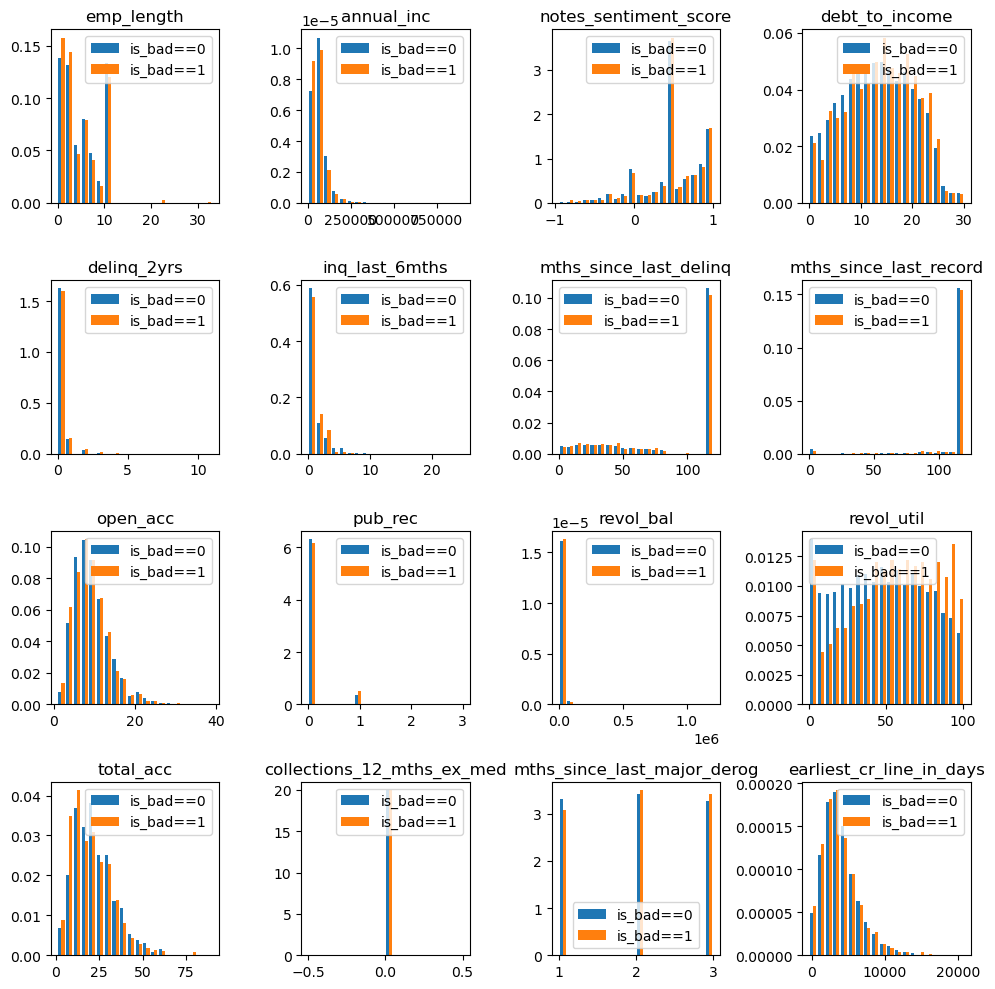

In [39]:
# Create a 4x4 grid of subplots
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

# Specify histogram for each subplot
for index, column in enumerate(numerical):
    i = index//4
    j = index%4
    
    ax = axes[i,j]
    ax.hist([df_fulfilled[column],df_default[column]],bins=20,density=True)
    ax.set_title(f'{column}')
    ax.legend(['is_bad==0','is_bad==1'])

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

Qualitative analysis tells us that for most of the numerical columns, distribution between fulfilled and defaulted datasets show little difference. 

The largest difference however is in the `revol_util` column. Let's take a careful look at that histogram.

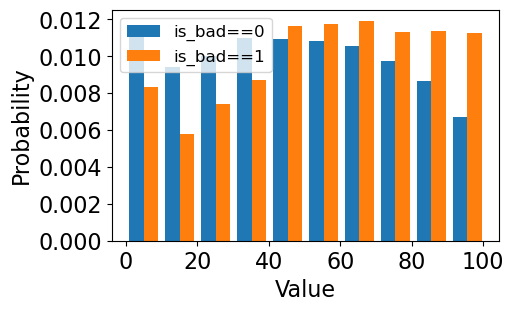

In [40]:
plt.figure(figsize=(5,3))
plt.hist([df_fulfilled['revol_util'],df_default['revol_util']],bins=10,density=True);

font = 16
plt.xlabel('Value',size=font);
plt.ylabel('Probability',size=font);
plt.xticks(size=font);
plt.yticks(size=font);
plt.legend(['is_bad==0','is_bad==1'],fontsize=font-4);

We see that for fulfilled cases, there are more probability in the lower value region of `revol_util`, around 20. For the defaulted cases, there  are more probability in the higher value region of `revol_util`, greater than 80.

### ```StandardScaler``` for numerical columns and ```OneHotEncoder``` for categorical (nominal) columns

Make intermediate ```df_target```

In [41]:
df_target = pd.DataFrame(df_raw[target].values,columns=target)

Make intermediate ```df_numerical```

In [42]:
# Define standardscaler
std = StandardScaler()

df_numerical = pd.DataFrame(std.fit_transform(df_raw[numerical]),
                            columns=numerical)

df_numerical.head()

,emp_length,annual_inc,notes_sentiment_score,debt_to_income,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,collections_12_mths_ex_med,mths_since_last_major_derog,earliest_cr_line_in_days
0,1.467365,-0.376055,-0.002173,-0.368879,-0.292927,-0.726593,0.722798,0.226534,1.250521,-0.239241,-0.086608,-1.288408,1.877033,0.0,-1.235345,0.617844
1,-1.109345,-0.598395,-1.746913,-0.623710,-0.292927,0.638625,0.722798,0.226534,-1.182702,-0.239241,-0.164596,0.550947,-1.457596,0.0,-0.002107,-1.272006
2,-0.250442,-0.066792,-0.002173,-0.314061,-0.292927,-0.726593,0.722798,0.226534,-1.182702,-0.239241,-0.561172,-1.695973,-1.201086,0.0,1.231130,3.910059
3,1.467365,-0.221424,-0.002173,-1.063738,1.690759,-0.726593,-1.715720,0.226534,-0.740298,-0.239241,-0.167916,-0.402399,0.081464,0.0,-0.002107,2.117546
4,1.467365,-0.375973,-2.445419,0.840087,-0.292927,2.003843,0.722798,0.226534,-0.297894,-0.239241,-0.139851,-0.285446,-0.089543,0.0,1.231130,-0.381557


Same for ```df_categorical```

In [43]:
# Define onehotencoder
enc = OneHotEncoder(handle_unknown='ignore',
                    drop='first')

df_categorical = pd.DataFrame(enc.fit_transform(df_raw[categorical]).toarray(),
                              columns=enc.get_feature_names_out(categorical))

df_categorical.head()

,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_VERIFIED - income source,verification_status_not verified,pymnt_plan_y,purpose_cat_1,purpose_cat_2,purpose_cat_3,purpose_cat_4,...,zip_code_first_digit_5,zip_code_first_digit_6,zip_code_first_digit_7,zip_code_first_digit_8,zip_code_first_digit_9,initial_list_status_m,policy_code_PC2,policy_code_PC3,policy_code_PC4,policy_code_PC5
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### Define ```X```, ```y```, and Put Aside Holdout

Before doing that, one thing we noticed from the histogram analysis is that there's an imbalance between `is_bad==0` and `is_bad==1` class. To resolve that issue, we're going to oversample from the `is_bad==1` class so that there are same number of data set for both classes. 

In [44]:
# Define the combined dataframe
df_combined = pd.concat([df_target,df_numerical,df_categorical],axis=1)

# Partition df_combined into 'is_bad'=0 and 1
df_isbad_0 = df_combined[df_combined['is_bad']==0]
df_isbad_1 = df_combined[df_combined['is_bad']==1]

# Oversample df_isbad_1 using the sample function
n_isbad_0 = np.shape(df_isbad_0)[0]
df_isbad_1_oversample = df_isbad_1.sample(n_isbad_0, replace=True)

#Combine the two and test the models (just do the holdout this time)
df_oversample = pd.concat([df_isbad_0,df_isbad_1_oversample],axis=0)

We're going to use `df_oversample` as the dataset of choice. 

In [45]:
# Divide into X and y
X = df_oversample.drop(['is_bad'],axis=1)
y = df_oversample['is_bad']

In [46]:
X, X_holdout, y, y_holdout = train_test_split(X, y, test_size=0.2, random_state=869255)

### Define CV Folds

In [47]:
n_splits = 5
folds = StratifiedKFold(n_splits=n_splits)

# Prepare the Models

For completeness, I'll use all three methods suggested in the task (logistic regression, GBM, and NN). However, due to computational cost, I will only do CV fold on the first two. For the NN, the model will only be tested on the holdout dataset. 

In [55]:
# Logistic regression 
LR = LogisticRegression(max_iter=5000)

# GBM
# Parameter from documentation 
GBM = GradientBoostingClassifier()

To tune the hyperparameter, we're going to use `GridSearchCV`. The choice of hyperparameters to sweep are relatively coarse due to computational cost, but further optimization could be possible.

### Logistic regression

In [57]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters
param_grid = {
    'C': [0.1, 0.5, 1, 2, 5, 10, 100]
}

# Create a grid search object
grid_search = GridSearchCV(estimator=LR, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the grid search to your data
grid_search.fit(X_holdout, y_holdout)

print(f'Best hyperparameter: {grid_search.best_params_}')
print(f'Best accuracy: {best_model.score(X_holdout, y_holdout)}')

# Get the best model
LR_best = grid_search.best_estimator_

Best hyperparameter: {'C': 5}
Best accuracy: 0.6159399364712677


### GBM

In [62]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters
param_grid = {
    'n_estimators': [50, 100, 500],
    'learning_rate': [0.05, 1, 2],
    'max_depth': [1, 2, 4]
}

# Create a grid search object
grid_search = GridSearchCV(estimator=GBM, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the grid search to your data
grid_search.fit(X_holdout, y_holdout)

print(f'Best hyperparameter: {grid_search.best_params_}')
print(f'Best accuracy: {best_model.score(X_holdout, y_holdout)}')

# Get the best model
GBM_best = grid_search.best_estimator_

Best hyperparameter: {'learning_rate': 1, 'max_depth': 4, 'n_estimators': 500}
Best accuracy: 0.6159399364712677


Great! We'll use the two best models (`LR_best` and `GBM_best`) to do CV and test on the holdout dataset.

Define CV fold function to train and evaluate the model

In [63]:
def evaluate_model(model, X, y, CVfold):
    # Define metrics of the model
    LL = np.zeros(CVfold.n_splits)
    F1 = np.zeros(CVfold.n_splits)
    accuracy = np.zeros(CVfold.n_splits)
    
    for i, (train, test) in enumerate(CVfold.split(X,y)):
        print(f'CV {i+1} out of {CVfold.n_splits}')
        
        # Split X and y
        X_train = X.iloc[train]
        X_test = X.iloc[test]
        y_train = y.iloc[train]
        y_test = y.iloc[test]
    
        # Train the model
        model.fit(X_train, y_train)
        
        # Get y_pred (predicted binary) y_pred_prob (predicted binary probability to be 1, hence [:,1])
        y_pred = model.predict(X_test)
        y_pred_prob = model.predict_proba(X_test)[:,1]
        
        # Get the stats
        LL[i] = log_loss(y_test, y_pred_prob)
        F1[i] = f1_score(y_test, y_pred)
        accuracy[i] = model.score(X_test, y_test)
        
    return LL, F1, accuracy

Same for using the holdout dataset

In [64]:
def evaluate_model_holdout(model, X, y, X_holdout, y_holdout):
    # Train the model
    model.fit(X, y)

    # Get y_pred (predicted binary) y_pred_prob (predicted binary probability to be 1, hence [:,1])
    y_pred = model.predict(X_holdout)
    y_pred_prob = model.predict_proba(X_holdout)[:,1]

    # Get the stats
    LL = log_loss(y_holdout, y_pred_prob)
    F1 = f1_score(y_holdout, y_pred)
    accuracy = model.score(X_holdout, y_holdout)
        
    return LL, F1, accuracy, y_pred

# Train and Evaluate Logistic Regression and GBM

Evaluate two sklearn models

In [65]:
log_loss_LR, F1_LR, accuracy_LR = evaluate_model(model=LR_best,
                                                 X=X,
                                                 y=y,
                                                 CVfold=folds)

log_loss_GBM, F1_GBM, accuracy_GBM = evaluate_model(model=GBM_best,
                                                   X=X,
                                                   y=y,
                                                   CVfold=folds)

print('Logistic regression:')
print(f'Log loss mean: {np.mean(log_loss_LR):0.2f}')
print(f'F1 score mean: {np.mean(F1_LR):0.2f}')
print(f'Accuracy mean: {np.mean(accuracy_LR):0.2f}')
print()
print('Gradient boost machine:')
print(f'Log loss mean: {np.mean(log_loss_GBM):0.2f}')
print(f'F1 score mean: {np.mean(F1_GBM):0.2f}')
print(f'Accuracy mean: {np.mean(accuracy_GBM):0.2f}')

CV 1 out of 5
CV 2 out of 5
CV 3 out of 5
CV 4 out of 5
CV 5 out of 5
CV 1 out of 5
CV 2 out of 5
CV 3 out of 5
CV 4 out of 5
CV 5 out of 5
Logistic regression:
Log loss mean: 0.66
F1 score mean: 0.60
Accuracy mean: 0.59

Gradient boost machine:
Log loss mean: 0.21
F1 score mean: 0.94
Accuracy mean: 0.94


We see that the for all three metrics, GBM outperforms logistic regression. This can be attributed to the strength of ensemble methods in dealing with nonlinear dataset opposed to logistic regression classifier which is linear. 

The non-linearity of the dataset can be examined by looking at the correlation matrix as shown below. 

In [81]:
correlation_matrix = df_oversample.corr()
target_correlations = correlation_matrix['is_bad'].abs().sort_values(ascending=False)
target_correlations

is_bad                                          1.000000
revol_util                                      0.125710
total_acc                                       0.090148
verification_status_not verified                0.080986
annual_inc                                      0.071255
purpose_cat_3                                   0.065386
purpose_cat_2                                   0.047989
zip_code_first_digit_3                          0.046469
policy_code_PC3                                 0.045737
purpose_cat_1                                   0.045499
emp_length                                      0.044462
zip_code_first_digit_1                          0.043213
zip_code_first_digit_5                          0.040516
policy_code_PC2                                 0.040072
debt_to_income                                  0.038692
open_acc                                        0.037568
pub_rec                                         0.035398
home_ownership_RENT            

We see that the column with the most correlation `revol_util` only has value of 0.1257, suggesting low correlation and nonlinearity between the target variable and other features.

Let's test the models on the holdout dataset

In [66]:
log_loss_LR_holdout, F1_LR_holdout, accuracy_LR_holdout, y_pred_LR = \
evaluate_model_holdout(model=LR_best,
                       X=X,
                       y=y,
                       X_holdout=X_holdout,
                       y_holdout=y_holdout)

log_loss_GBM_holdout, F1_GBM_holdout, accuracy_GBM_holdout, y_pred_GBM = \
evaluate_model_holdout(model=GBM_best,
                       X=X,
                       y=y,
                       X_holdout=X_holdout,
                       y_holdout=y_holdout)

print('Logistic regression:')
print(f'Log loss: {log_loss_LR_holdout:0.2f}')
print(f'F1 score: {F1_LR_holdout:0.2f}')
print(f'Accuracy: {accuracy_LR_holdout:0.2f}')
print()
print('Gradient boost machine:')
print(f'Log loss: {log_loss_GBM_holdout:0.2f}')
print(f'F1 score: {F1_GBM_holdout:0.2f}')
print(f'Accuracy: {accuracy_GBM_holdout:0.2f}')

Logistic regression:
Log loss: 0.66
F1 score: 0.62
Accuracy: 0.61

Gradient boost machine:
Log loss: 0.12
F1 score: 0.96
Accuracy: 0.96


We see same trend as we did for cross-validation.

Let's look at classification report

In [82]:
print('Classification report for: Logistic Regression')
print(classification_report(y_holdout, pd.DataFrame(y_pred_LR)))

Classification report for: Logistic Regression
              precision    recall  f1-score   support

           0       0.61      0.57      0.59      1714
           1       0.60      0.64      0.62      1749

    accuracy                           0.61      3463
   macro avg       0.61      0.61      0.61      3463
weighted avg       0.61      0.61      0.61      3463



In [83]:
print('Classification report for: GBM')
print(classification_report(y_holdout, y_pred_GBM))

Classification report for: GBM
              precision    recall  f1-score   support

           0       1.00      0.91      0.95      1714
           1       0.92      1.00      0.96      1749

    accuracy                           0.96      3463
   macro avg       0.96      0.95      0.96      3463
weighted avg       0.96      0.96      0.96      3463



# Neural Network

We'll do a simple NN without any hidden layer due to high computational cost of tuning the hyperparameter. Here I'm using only one hidden layer with 100 neurons as the problem is relatively simple (as in GBM performs well).

In [85]:
# Define the model
NN = keras.Sequential([
     keras.layers.Dense(100, input_shape=(np.shape(X)[1],), activation='relu'), 
     keras.layers.Dense(100, activation='relu'),
     keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
NN.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Fit the model
NN.fit(X, y, epochs=10)

2023-09-29 15:21:38.656229: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-29 15:21:38.729374: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/10
433/433 [==============================] - 1s 654us/step - loss: 0.6722 - accuracy: 0.5789
Epoch 2/10
433/433 [==============================] - 0s 609us/step - loss: 0.6093 - accuracy: 0.6619
Epoch 3/10
433/433 [==============================] - 0s 672us/step - loss: 0.5675 - accuracy: 0.7009
Epoch 4/10
433/433 [==============================] - 0s 614us/step - loss: 0.5211 - accuracy: 0.7413
Epoch 5/10
433/433 [==============================] - 0s 602us/step - loss: 0.4741 - accuracy: 0.7842
Epoch 6/10
433/433 [==============================] - 0s 610us/step - loss: 0.4161 - accuracy: 0.8202
Epoch 7/10
433/433 [==============================] - 0s 642us/step - loss: 0.3898 - accuracy: 0.8415
Epoch 8/10
433/433 [==============================] - 0s 616us/step - loss: 0.3391 - accuracy: 0.8670
Epoch 9/10
433/433 [==============================] - 0s 607us/step - loss: 0.3056 - accuracy: 0.8860
Epoch 10/10
433/433 [==============================] - 0s 638us/step - loss: 0.271

In [86]:
# Get prediction and probability for the test dataset
y_pred_NN = np.transpose(NN.predict_classes(X_holdout))[0]
y_pred_prob_NN = np.transpose(NN.predict(X_holdout))[0]

# Get stats
log_loss_NN_holdout = log_loss(y_holdout, y_pred_prob_NN)
F1_NN_holdout = f1_score(y_holdout, y_pred_NN)
accuracy_NN_holdout = NN.evaluate(X_holdout, y_holdout)[1]

/Users/WHR/opt/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


109/109 [==============================] - 0s 453us/step - loss: 0.3649 - accuracy: 0.8530


In [87]:
print('Neural network:')
print(f'Log loss: {log_loss_NN_holdout}')
print(f'F1 score: {F1_NN_holdout}')
print(f'Accuracy: {accuracy_NN_holdout}')

Neural network:
Log loss: 0.36489212972156565
F1 score: 0.8658761528326746
Accuracy: 0.8530176281929016


We see that compared to GBM, NN performs slightly worse with higher log loss and lower F1 and accuracy, but much better than logistic regression. 

In [89]:
print('Classification report for: NN')
print(classification_report(y_holdout, y_pred_NN))

Classification report for: NN
              precision    recall  f1-score   support

           0       0.93      0.76      0.84      1714
           1       0.80      0.94      0.87      1749

    accuracy                           0.85      3463
   macro avg       0.86      0.85      0.85      3463
weighted avg       0.86      0.85      0.85      3463



# Three Most Important Features

Since all three models give comparable performance in terms of log loss, F1 score, and accuracy, let's see what the three most important features are for the ML models (not straightforward in NN)

### Linear Regression

In [90]:
feature_indices = np.argsort(np.abs(LR_best.coef_[0]))
print('Linear regression:')
print(f'1st important feature:')
print(f'{X.columns[feature_indices[-1]]}, abs(coef): {np.abs(LR_best.coef_[0])[feature_indices[-1]]:0.2f}')
print(f'2nd important feature:')
print(f'{X.columns[feature_indices[-2]]}, abs(coef): {np.abs(LR_best.coef_[0])[feature_indices[-2]]:0.2f}')
print(f'3rd important feature:')
print(f'{X.columns[feature_indices[-3]]}, abs(coef): {np.abs(LR_best.coef_[0])[feature_indices[-3]]:0.2f}')

Linear regression:
1st important feature:
pymnt_plan_y, abs(coef): 2.37
2nd important feature:
initial_list_status_m, abs(coef): 1.66
3rd important feature:
purpose_cat_1, abs(coef): 1.31


### GBM

In [91]:
feature_indices = np.argsort(GBM_best.feature_importances_)
print('GBM:')
print(f'1st important feature:')
print(f'{X.columns[feature_indices[-1]]}, abs(coef): {GBM_best.feature_importances_[feature_indices[-1]]:0.2f}')
print(f'2nd important feature:')
print(f'{X.columns[feature_indices[-2]]}, abs(coef): {GBM_best.feature_importances_[feature_indices[-2]]:0.2f}')
print(f'3rd important feature:')
print(f'{X.columns[feature_indices[-3]]}, abs(coef): {GBM_best.feature_importances_[feature_indices[-3]]:0.2f}')

GBM:
1st important feature:
revol_bal, abs(coef): 0.14
2nd important feature:
revol_util, abs(coef): 0.12
3rd important feature:
debt_to_income, abs(coef): 0.11


# Recommended Model to Use

Considering the performance of the GBM model over logistic regression and neural network, I would recommend using **gradient boosting machine** for this loan default classification problem. 

Note that it's possible to improve upon the NN model using this dataset, but I believe GBM will still be better to use as it will be faster in classifying new data. 